In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import shapiro

import statsmodels.formula.api as smf


Financial timeseries data

In finance, it is common to be working with a CSV (comma-separated-values) "flat" file of a timeseries of many different assets with their prices, returns, or other data over time. Sometimes the data is stored in databases, but more often than not, even large banks still use spreadsheets.

In this exercise, you have been given a timeseries of trading data for Microsoft stock as a .csv file

In [2]:
# Read in the csv file and parse dates
StockPrices = pd.read_csv('MSFTPrices.csv', parse_dates=['Date'])

# Ensure the prices are sorted by Date
StockPrices = StockPrices.sort_values(by='Date')

StockPrices

,Date,Open,High,Low,Close,Volume,Adjusted
0,2000-01-03,88.777,89.722,84.712,58.281250,53228400,38.527809
1,2000-01-04,85.893,88.588,84.901,56.312500,54119000,37.226345
2,2000-01-05,84.050,88.021,82.726,56.906250,64059600,37.618851
3,2000-01-06,84.853,86.130,81.970,55.000000,54976600,36.358688
4,2000-01-07,82.159,84.901,81.166,55.718750,62013600,36.833828
...,...,...,...,...,...,...,...
4556,2018-02-12,89.157,90.202,88.343,89.129997,35720300,88.713272
4557,2018-02-13,89.348,90.423,88.212,89.830002,26407700,89.410004
4558,2018-02-14,88.510,90.990,88.410,90.809998,34960900,90.809998
4559,2018-02-15,91.210,92.720,90.620,92.660004,27823900,92.660004


Calculating financial returns

The file you loaded in the previous exercise included daily Open, High, Low, Close, Adjusted Close, and Volume data, often referred to as OHLCV data.

The Adjusted Close column is the most important. It is normalized for stock splits, dividends, and other corporate actions, and is a true reflection of the return of the stock over time.

In [3]:
# Calculate the daily returns of the adjusted close price
StockPrices['Returns'] = StockPrices['Adjusted'].pct_change()

StockPrices

,Date,Open,High,Low,Close,Volume,Adjusted,Returns
0,2000-01-03,88.777,89.722,84.712,58.281250,53228400,38.527809,NaN
1,2000-01-04,85.893,88.588,84.901,56.312500,54119000,37.226345,-0.033780
2,2000-01-05,84.050,88.021,82.726,56.906250,64059600,37.618851,0.010544
3,2000-01-06,84.853,86.130,81.970,55.000000,54976600,36.358688,-0.033498
4,2000-01-07,82.159,84.901,81.166,55.718750,62013600,36.833828,0.013068
...,...,...,...,...,...,...,...,...
4556,2018-02-12,89.157,90.202,88.343,89.129997,35720300,88.713272,0.010773
4557,2018-02-13,89.348,90.423,88.212,89.830002,26407700,89.410004,0.007854
4558,2018-02-14,88.510,90.990,88.410,90.809998,34960900,90.809998,0.015658
4559,2018-02-15,91.210,92.720,90.620,92.660004,27823900,92.660004,0.020372


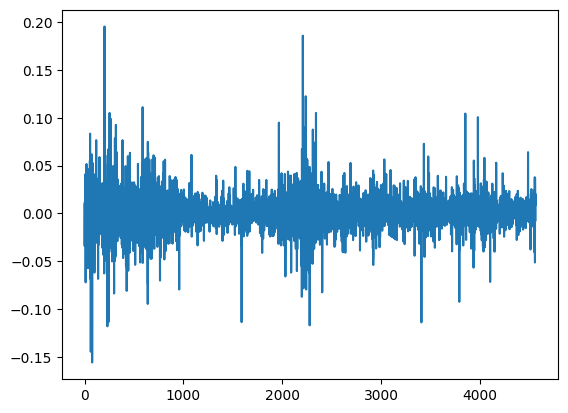

In [4]:
# Plot the returns column over time
StockPrices['Returns'].plot()
plt.show()

Return distributions

In order to analyze the probability of outliers in returns, it is helpful to visualize the historical returns of a stock using a histogram.

You can use the histogram to show the historical density or frequency of a given range of returns. Note the outliers on the left tail of the return distribution are what you often want to avoid, as they represent large negative daily returns. Outliers on the right hand side of the distribution are normally particularly good events for the stock such as a positive earnings surprise.

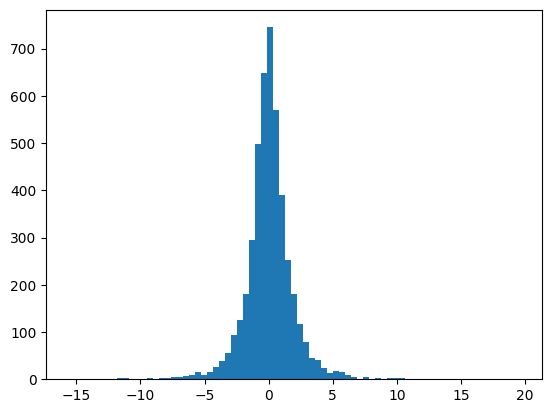

In [5]:
# Convert the decimal returns into percentage returns
percent_return = StockPrices['Returns']*100

# Drop the missing values
returns_plot = percent_return.dropna()

# Plot the returns histogram
plt.hist(returns_plot, bins=75)
plt.show()

First moment: Mu

You can calculate the average historical return of a stock by using numpy's mean() function.

When you are calculating the average daily return of a stock, you are essentially estimating the first moment ( 
 ) of the historical returns distribution.

But what use are daily return estimates to a long-term investor? You can use the formula with compounding to estimate the average annual return of a stock given the average daily return and the number of trading days in a year (typically there are roughly 252 trading days in a year)

In [6]:
# Calculate the average daily return of the stock
mean_return_daily = np.mean(StockPrices['Returns'])
print(mean_return_daily)

0.00037777546435757676


In [7]:
# Calculate the implied annualized average return
mean_return_annualized = ((1 + mean_return_daily)**252) - 1
print(mean_return_annualized)

0.09985839482852632


Second moment: Variance

Just like you estimated the first moment of the returns distribution in the last exercise, you can can also estimate the second moment, or variance of a return distribution using numpy.

In this case, you will first need to calculate the daily standard deviation ( sigma ), or volatility of the returns using np.std(). The variance is simply sigma^2.

In [8]:
# Calculate the standard deviation of daily return of the stock
sigma_daily = np.std(StockPrices['Returns'])
print(sigma_daily)

0.019341100408708317


In [9]:
# Calculate the daily variance
variance_daily = sigma_daily**2
print(variance_daily)

0.00037407816501973704


Annualizing variance

You can't annualize the variance in the same way that you annualized the mean.

In this case, you will need to multiply 
 by the square root of the number of trading days in a year. There are typically 252 trading days in a calendar year. Let's assume this is the case for this exercise.

This will get you the annualized volatility, but to get annualized variance, you'll need to square the annualized volatility just like you did for the daily calculation.

In [10]:
# Annualize the standard deviation
sigma_annualized = sigma_daily*np.sqrt(252)
print(sigma_annualized)

0.3070304505826315


In [11]:
# Calculate the annualized variance
variance_annualized = sigma_annualized**2
print(variance_annualized)

0.09426769758497373


Third moment: Skewness

To calculate the third moment, or skewness of a returns distribution in Python, you can use the skew() function from scipy.stats.

Remember that a negative skew is a right-leaning curve, while positive skew is a left-leaning curve. In finance, you would tend to want positive skewness, as this would mean that the probability of large positive returns is unusually high, and the negative returns are more closely clustered and predictable.

In [12]:
# Drop the missing values
clean_returns = StockPrices.Returns.dropna()
clean_returns

1      -0.033780
2       0.010544
3      -0.033498
4       0.013068
5       0.007291
          ...   
4556    0.010773
4557    0.007854
4558    0.015658
4559    0.020372
4560   -0.007123
Name: Returns, Length: 4560, dtype: float64

In [13]:
# Calculate the third moment (skewness) of the returns distribution
returns_skewness = skew(clean_returns)
print(returns_skewness)

0.21935459193067805


Fourth moment: Kurtosis

Finally, to calculate the fourth moment of a distribution, you can use the kurtosis() function from scipy.stats.

Note that this function actually returns the excess kurtosis, not the 4th moment itself. In order to calculate kurtosis, simply add 3 to the excess kurtosis returned by kurtosis().

In [14]:
# Calculate the excess kurtosis of the returns distribution
excess_kurtosis = kurtosis(clean_returns)
print(excess_kurtosis)

# Derive the true fourth moment of the returns distribution
fourth_moment = excess_kurtosis + 3
print(fourth_moment)

10.314572618025519
13.314572618025519


Statistical tests for normality

In order to truly be confident in your judgement of the normality of the stock's return distribution, you will want to use a true statistical test rather than simply examining the kurtosis or skewness.

You can use the shapiro() function from scipy.stats to run a Shapiro-Wilk test of normality on the stock returns. The function will return two values in a list. The first value is the t-stat of the test, and the second value is the p-value. You can use the p-value to make a judgement about the normality of the data. If the p-value is less than or equal to 0.05, you can safely reject the null hypothesis of normality and assume that the data are non-normally distributed.

In [15]:
# Run the Shapiro-Wilk test on the stock returns
shapiro_results = shapiro(clean_returns)
shapiro_results

ShapiroResult(statistic=0.9003648428746107, pvalue=1.63104738942256e-47)

Calculating portfolio returns

In order to build and backtest a portfolio, you have to be comfortable working with the returns of multiple assets in a single object.

In this exercise, you will be using a pandas DataFrame object, already stored as the variable StockReturns, to hold the returns of multiple assets and to calculate the returns of a model portfolio.

The model portfolio is constructed with pre-defined weights for some of the largest companies in the world just before January 2017:

Company Name	Ticker	Portfolio Weight

Apple	AAPL	12%

Microsoft	MSFT	15%

Exxon Mobil	XOM	8%

Johnson & Johnson	JNJ	5%

JP Morgan	JPM	9%

Amazon	AMZN	10%

General Electric	GE	11%

Facebook	FB	14%

AT&T	T	16%

In [16]:
StockReturns = pd.read_csv('Big9Returns2017.csv', index_col=0)
StockReturns

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T
Date,,,,,,,,,
2017-01-03,0.002849,0.007081,0.006980,0.005468,0.010894,0.005068,0.002848,0.015732,0.011521
2017-01-04,-0.001119,-0.004474,-0.011002,-0.001640,0.001844,0.004657,0.000316,0.015660,-0.005811
2017-01-05,0.005085,0.000000,-0.014907,0.010463,-0.009205,0.030732,-0.005678,0.016682,-0.002806
2017-01-06,0.011148,0.008668,-0.000565,-0.004792,0.000116,0.019912,0.002855,0.022707,-0.019924
2017-01-09,0.009159,-0.003183,-0.016497,-0.000172,0.000697,0.001168,-0.004745,0.012074,-0.012585
...,...,...,...,...,...,...,...,...,...
2017-12-22,0.000000,0.000117,0.001431,-0.006664,-0.003524,-0.005448,0.001717,-0.001409,0.001543
2017-12-26,-0.025370,-0.001286,0.000119,-0.000214,-0.004002,0.007190,0.002877,-0.006828,0.003082
2017-12-27,0.000176,0.003630,-0.000953,0.003426,0.001869,0.004674,-0.002869,0.009262,-0.004352


In [17]:
# Finish defining the portfolio weights as a numpy array
portfolio_weights = np.array([0.12, 0.15, 0.08, 0.05, 0.09, 0.10, 0.11, 0.14, 0.16])

# Calculate the weighted stock returns
WeightedReturns = StockReturns.mul(portfolio_weights, axis=1)
WeightedReturns

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T
Date,,,,,,,,,
2017-01-03,0.000342,0.001062,0.000558,0.000273,0.000980,0.000507,0.000313,0.002203,0.001843
2017-01-04,-0.000134,-0.000671,-0.000880,-0.000082,0.000166,0.000466,0.000035,0.002192,-0.000930
2017-01-05,0.000610,0.000000,-0.001193,0.000523,-0.000828,0.003073,-0.000625,0.002335,-0.000449
2017-01-06,0.001338,0.001300,-0.000045,-0.000240,0.000010,0.001991,0.000314,0.003179,-0.003188
2017-01-09,0.001099,-0.000477,-0.001320,-0.000009,0.000063,0.000117,-0.000522,0.001690,-0.002014
...,...,...,...,...,...,...,...,...,...
2017-12-22,0.000000,0.000018,0.000114,-0.000333,-0.000317,-0.000545,0.000189,-0.000197,0.000247
2017-12-26,-0.003044,-0.000193,0.000010,-0.000011,-0.000360,0.000719,0.000316,-0.000956,0.000493
2017-12-27,0.000021,0.000545,-0.000076,0.000171,0.000168,0.000467,-0.000316,0.001297,-0.000696


In [18]:
# Calculate the portfolio returns
StockReturns['Portfolio'] = WeightedReturns.sum(axis=1)
StockReturns

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T,Portfolio
Date,,,,,,,,,,
2017-01-03,0.002849,0.007081,0.006980,0.005468,0.010894,0.005068,0.002848,0.015732,0.011521,0.008082
2017-01-04,-0.001119,-0.004474,-0.011002,-0.001640,0.001844,0.004657,0.000316,0.015660,-0.005811,0.000161
2017-01-05,0.005085,0.000000,-0.014907,0.010463,-0.009205,0.030732,-0.005678,0.016682,-0.002806,0.003448
2017-01-06,0.011148,0.008668,-0.000565,-0.004792,0.000116,0.019912,0.002855,0.022707,-0.019924,0.004660
2017-01-09,0.009159,-0.003183,-0.016497,-0.000172,0.000697,0.001168,-0.004745,0.012074,-0.012585,-0.001372
...,...,...,...,...,...,...,...,...,...,...
2017-12-22,0.000000,0.000117,0.001431,-0.006664,-0.003524,-0.005448,0.001717,-0.001409,0.001543,-0.000825
2017-12-26,-0.025370,-0.001286,0.000119,-0.000214,-0.004002,0.007190,0.002877,-0.006828,0.003082,-0.003026
2017-12-27,0.000176,0.003630,-0.000953,0.003426,0.001869,0.004674,-0.002869,0.009262,-0.004352,0.001581


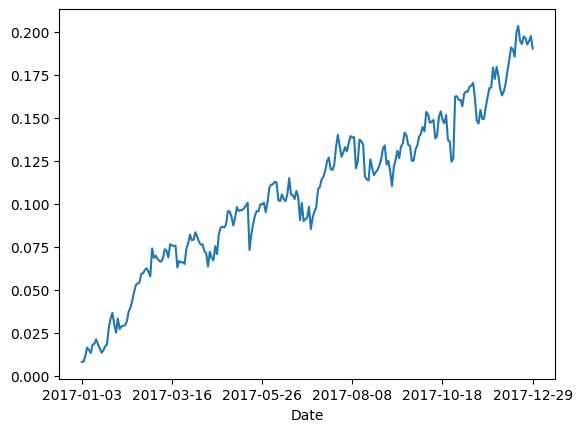

In [19]:
# Plot the cumulative portfolio returns over time
CumulativeReturns = ((1+StockReturns["Portfolio"]).cumprod()-1)
CumulativeReturns.plot()
plt.show()

Equal weighted portfolios

When comparing different portfolios, you often want to consider performance versus a naive equally-weighted portfolio. If the portfolio doesn't outperform a simple equally weighted portfolio, you might want to consider another strategy, or simply opt for the naive approach if all else fails. You can expect equally-weighted portfolios to tend to outperform the market when the largest companies are doing poorly. This is because even tiny companies would have the same weight in your equally-weighted portfolio as Apple or Amazon, for example.

In [20]:
def cumulative_returns_plot(cols): 
    """
    cols: A list of column names to plot 
    """
    
    CumulativeReturns = ((1+StockReturns[cols]).cumprod()-1) 
    CumulativeReturns.plot() 
    plt.show()

In [21]:
# How many stocks are in your portfolio?
numstocks = 9

# Create an array of equal weights across all assets
portfolio_weights_ew = np.repeat(1/numstocks,numstocks)

portfolio_weights_ew

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111])

In [22]:
# Calculate the equally-weighted portfolio returns
StockReturns['Portfolio_EW'] = StockReturns.iloc[:, :9].mul(portfolio_weights_ew, axis=1).sum(axis=1)
StockReturns

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T,Portfolio,Portfolio_EW
Date,,,,,,,,,,,
2017-01-03,0.002849,0.007081,0.006980,0.005468,0.010894,0.005068,0.002848,0.015732,0.011521,0.008082,0.007605
2017-01-04,-0.001119,-0.004474,-0.011002,-0.001640,0.001844,0.004657,0.000316,0.015660,-0.005811,0.000161,-0.000174
2017-01-05,0.005085,0.000000,-0.014907,0.010463,-0.009205,0.030732,-0.005678,0.016682,-0.002806,0.003448,0.003374
2017-01-06,0.011148,0.008668,-0.000565,-0.004792,0.000116,0.019912,0.002855,0.022707,-0.019924,0.004660,0.004458
2017-01-09,0.009159,-0.003183,-0.016497,-0.000172,0.000697,0.001168,-0.004745,0.012074,-0.012585,-0.001372,-0.001565
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,0.000000,0.000117,0.001431,-0.006664,-0.003524,-0.005448,0.001717,-0.001409,0.001543,-0.000825,-0.001360
2017-12-26,-0.025370,-0.001286,0.000119,-0.000214,-0.004002,0.007190,0.002877,-0.006828,0.003082,-0.003026,-0.002715
2017-12-27,0.000176,0.003630,-0.000953,0.003426,0.001869,0.004674,-0.002869,0.009262,-0.004352,0.001581,0.001651


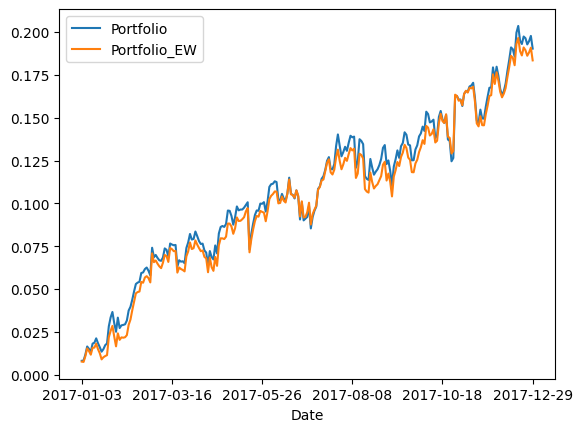

In [23]:
cumulative_returns_plot(['Portfolio', 'Portfolio_EW'])

Market-cap weighted portfolios

Conversely, when large companies are doing well, market capitalization, or "market cap" weighted portfolios tend to outperform. This is because the largest weights are being assigned to the largest companies, or the companies with the largest market cap.

Below is a table of the market capitalizations of the companies in your portfolio just before January 2017:


Company Name	Ticker	Market Cap ($ Billions)

Apple	AAPL	601.51

Microsoft	MSFT	469.25

Exxon Mobil	XOM	349.5

Johnson & Johnson	JNJ	310.48

JP Morgan	JPM	299.77

Amazon	AMZN	356.94

General Electric	GE	268.88

Facebook	FB	331.57

AT&T	T	246.09

In [24]:
# Create an array of market capitalizations (in billions)
market_capitalizations = np.array([601.51, 469.25, 349.5, 310.48, 299.77, 356.94, 268.88, 331.57, 246.09])

# Calculate the market cap weights
mcap_weights = market_capitalizations/sum(market_capitalizations)
mcap_weights

array([0.18599625, 0.1450994 , 0.10807084, 0.09600524, 0.09269355,
       0.1103714 , 0.08314188, 0.1025266 , 0.07609485])

In [25]:
# Calculate the market cap weighted portfolio returns
StockReturns['Portfolio_MCap'] = StockReturns.iloc[:, 0:9].mul(mcap_weights, axis=1).sum(axis=1)
StockReturns

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T,Portfolio,Portfolio_EW,Portfolio_MCap
Date,,,,,,,,,,,,
2017-01-03,0.002849,0.007081,0.006980,0.005468,0.010894,0.005068,0.002848,0.015732,0.011521,0.008082,0.007605,0.007132
2017-01-04,-0.001119,-0.004474,-0.011002,-0.001640,0.001844,0.004657,0.000316,0.015660,-0.005811,0.000161,-0.000174,-0.000329
2017-01-05,0.005085,0.000000,-0.014907,0.010463,-0.009205,0.030732,-0.005678,0.016682,-0.002806,0.003448,0.003374,0.003903
2017-01-06,0.011148,0.008668,-0.000565,-0.004792,0.000116,0.019912,0.002855,0.022707,-0.019924,0.004660,0.004458,0.006068
2017-01-09,0.009159,-0.003183,-0.016497,-0.000172,0.000697,0.001168,-0.004745,0.012074,-0.012585,-0.001372,-0.001565,-0.000478
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,0.000000,0.000117,0.001431,-0.006664,-0.003524,-0.005448,0.001717,-0.001409,0.001543,-0.000825,-0.001360,-0.001280
2017-12-26,-0.025370,-0.001286,0.000119,-0.000214,-0.004002,0.007190,0.002877,-0.006828,0.003082,-0.003026,-0.002715,-0.004717
2017-12-27,0.000176,0.003630,-0.000953,0.003426,0.001869,0.004674,-0.002869,0.009262,-0.004352,0.001581,0.001651,0.001854


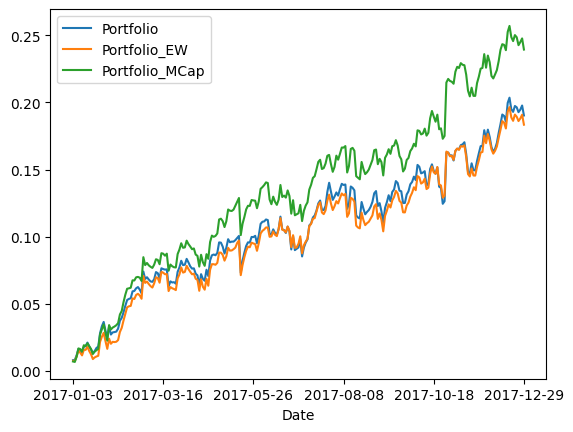

In [26]:
cumulative_returns_plot(['Portfolio', 'Portfolio_EW', 'Portfolio_MCap'])

The correlation matrix

The correlation matrix can be used to estimate the linear historical relationship between the returns of multiple assets. You can use the built-in .corr() method on a pandas DataFrame to easily calculate the correlation matrix.

Correlation ranges from -1 to 1. The diagonal of the correlation matrix is always 1, because a stock always has a perfect correlation with itself. The matrix is symmetric, which means that the lower triangle and upper triangle of the matrix are simply reflections of each other since correlation is a bi-directional measurement.

In [27]:
# Calculate the correlation matrix
correlation_matrix = StockReturns.iloc[:,:9].corr()

correlation_matrix

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T
AAPL,1.000000,0.437430,0.055505,0.038432,0.199914,0.509472,0.006766,0.542367,0.005082
MSFT,0.437430,1.000000,0.084108,0.230215,0.191248,0.621096,-0.044827,0.543341,-0.021079
XOM,0.055505,0.084108,1.000000,0.121012,0.305926,0.015118,0.193861,-0.046813,0.197576
JNJ,0.038432,0.230215,0.121012,1.000000,0.070328,0.052781,0.067930,0.079391,0.091622
JPM,0.199914,0.191248,0.305926,0.070328,1.000000,0.013919,0.257401,0.095245,0.252832
AMZN,0.509472,0.621096,0.015118,0.052781,0.013919,1.000000,-0.092188,0.653030,-0.017909
GE,0.006766,-0.044827,0.193861,0.067930,0.257401,-0.092188,1.000000,-0.024364,0.292706
FB,0.542367,0.543341,-0.046813,0.079391,0.095245,0.653030,-0.024364,1.000000,-0.024505
T,0.005082,-0.021079,0.197576,0.091622,0.252832,-0.017909,0.292706,-0.024505,1.000000


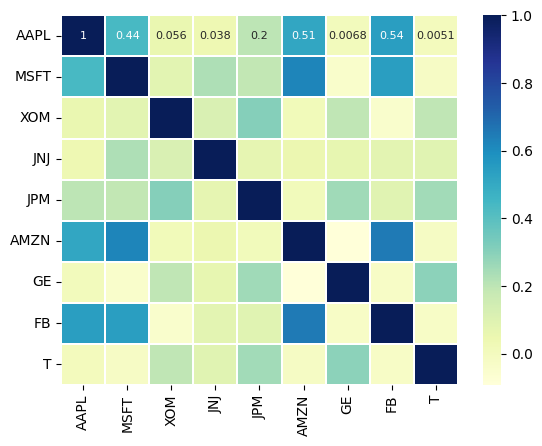

In [28]:
sns.heatmap(correlation_matrix,
            annot=True,
            cmap="YlGnBu", 
            linewidths=0.3,
            annot_kws={"size": 8}) 

# Plot aesthetics
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()


The co-variance matrix

You can easily compute the co-variance matrix of a DataFrame of returns using the .cov() method.

The correlation matrix doesn't really tell you anything about the variance of the underlying assets, only the linear relationships between assets. The co-variance (a.k.a. variance-covariance) matrix, on the other hand, contains all of this information, and is very useful for portfolio optimization and risk management purposes.

In [29]:
# Calculate the covariance matrix
cov_mat = StockReturns.iloc[:,:9].cov()
cov_mat

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T
AAPL,1.230004e-04,0.000045,0.000004,0.000003,0.000023,0.000075,9.366843e-07,0.000064,6.028459e-07
MSFT,4.523795e-05,0.000087,0.000006,0.000015,0.000018,0.000076,-5.218049e-06,0.000054,-2.102457e-06
XOM,4.335558e-06,0.000006,0.000050,0.000006,0.000022,0.000001,1.704432e-05,-0.000004,1.488464e-05
JNJ,3.072253e-06,0.000015,0.000006,0.000052,0.000005,0.000005,6.112208e-06,0.000006,7.064036e-06
JPM,2.268091e-05,0.000018,0.000022,0.000005,0.000105,0.000002,3.287008e-05,0.000010,2.766552e-05
AMZN,7.462331e-05,0.000076,0.000001,0.000005,0.000002,0.000174,-1.519864e-05,0.000092,-2.530026e-06
GE,9.366843e-07,-0.000005,0.000017,0.000006,0.000033,-0.000015,1.558316e-04,-0.000003,3.908441e-05
FB,6.445736e-05,0.000054,-0.000004,0.000006,0.000010,0.000092,-3.259186e-06,0.000115,-2.808798e-06
T,6.028459e-07,-0.000002,0.000015,0.000007,0.000028,-0.000003,3.908441e-05,-0.000003,1.144161e-04


In [30]:
# Annualize the co-variance matrix
cov_mat_annual = cov_mat * 252

cov_mat_annual

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T
AAPL,0.030996,0.011400,0.001093,0.000774,0.005716,0.018805,0.000236,0.016243,0.000152
MSFT,0.011400,0.021912,0.001392,0.003899,0.004597,0.019275,-0.001315,0.013682,-0.000530
XOM,0.001093,0.001392,0.012500,0.001548,0.005554,0.000354,0.004295,-0.000890,0.003751
JNJ,0.000774,0.003899,0.001548,0.013092,0.001307,0.001266,0.001540,0.001545,0.001780
JPM,0.005716,0.004597,0.005554,0.001307,0.026371,0.000474,0.008283,0.002631,0.006972
AMZN,0.018805,0.019275,0.000354,0.001266,0.000474,0.043954,-0.003830,0.023290,-0.000638
GE,0.000236,-0.001315,0.004295,0.001540,0.008283,-0.003830,0.039270,-0.000821,0.009849
FB,0.016243,0.013682,-0.000890,0.001545,0.002631,0.023290,-0.000821,0.028937,-0.000708
T,0.000152,-0.000530,0.003751,0.001780,0.006972,-0.000638,0.009849,-0.000708,0.028833


Portfolio standard deviation

In order to calculate portfolio volatility, you will need the covariance matrix, the portfolio weights, and knowledge of the transpose operation. The transpose of a numpy array can be calculated using the .T attribute. The np.dot() function is the dot-product of two arrays.

The formula for portfolio volatility is: σ = sqrt(𝑤^𝑇 × 𝛴 × 𝑤)

σ: Portfolio volatility

𝛴: Covariance matrix of returns

w: Portfolio weights (𝑤^𝑇 is transposed portfolio weights)

× is The dot-multiplication operator

In [31]:
# Calculate the portfolio standard deviation
portfolio_volatility = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_mat_annual, portfolio_weights)))
portfolio_volatility

0.08931417642713795

Sharpe 

The Sharpe ratio is a simple metric of risk adjusted return which was pioneered by William F. Sharpe. Sharpe ratio is useful to determine how much risk is being taken to achieve a certain level of return. In finance, you are always seeking ways to improve your Sharpe ratio, and the measure is very commonly quoted and used to compare investment strategies.

In [32]:
StockReturns

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T,Portfolio,Portfolio_EW,Portfolio_MCap
Date,,,,,,,,,,,,
2017-01-03,0.002849,0.007081,0.006980,0.005468,0.010894,0.005068,0.002848,0.015732,0.011521,0.008082,0.007605,0.007132
2017-01-04,-0.001119,-0.004474,-0.011002,-0.001640,0.001844,0.004657,0.000316,0.015660,-0.005811,0.000161,-0.000174,-0.000329
2017-01-05,0.005085,0.000000,-0.014907,0.010463,-0.009205,0.030732,-0.005678,0.016682,-0.002806,0.003448,0.003374,0.003903
2017-01-06,0.011148,0.008668,-0.000565,-0.004792,0.000116,0.019912,0.002855,0.022707,-0.019924,0.004660,0.004458,0.006068
2017-01-09,0.009159,-0.003183,-0.016497,-0.000172,0.000697,0.001168,-0.004745,0.012074,-0.012585,-0.001372,-0.001565,-0.000478
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,0.000000,0.000117,0.001431,-0.006664,-0.003524,-0.005448,0.001717,-0.001409,0.001543,-0.000825,-0.001360,-0.001280
2017-12-26,-0.025370,-0.001286,0.000119,-0.000214,-0.004002,0.007190,0.002877,-0.006828,0.003082,-0.003026,-0.002715,-0.004717
2017-12-27,0.000176,0.003630,-0.000953,0.003426,0.001869,0.004674,-0.002869,0.009262,-0.004352,0.001581,0.001651,0.001854


In [33]:
# Number of portfolios
n_portfolios = 100

# Number of stocks
stocks = ['AAPL weight', 'MSFT weight', 'XOM weight', 'JNJ weight', 'JPM weight', 'AMZN weight', 'GE weight', 'FB weight', 'T weight']

# Generate random weights and normalize to sum to 1
np.random.seed(42)  # For reproducibility
weights = np.random.dirichlet(np.ones(len(stocks)), size=n_portfolios)

# Generate random returns and volatilities
returns = np.random.uniform(0.1, 0.3, size=n_portfolios)
volatilities = np.random.uniform(0.1, 0.2, size=n_portfolios)

# Create the DataFrame
data={}

# Add the stock weights to the DataFrame
for i, stock in enumerate(stocks):
    data[stock] = weights[:, i]

data['Returns'] = returns
data['Volatility'] = volatilities

# Create the DataFrame
RandomPortfolios = pd.DataFrame(data)

RandomPortfolios


,AAPL weight,MSFT weight,XOM weight,JNJ weight,JPM weight,AMZN weight,GE weight,FB weight,T weight,Returns,Volatility
0,0.051919,0.333035,0.145683,0.101007,0.018767,0.018764,0.006620,0.222519,0.101686,0.141577,0.118513
1,0.148510,0.002509,0.422589,0.215474,0.028790,0.024205,0.024438,0.043754,0.089730,0.105306,0.154190
2,0.109224,0.066481,0.182776,0.029015,0.066731,0.088122,0.117606,0.297027,0.043018,0.136287,0.187295
3,0.066526,0.082694,0.004382,0.086180,0.017226,0.006198,0.273989,0.310563,0.152242,0.216608,0.173222
4,0.063208,0.017882,0.200566,0.100930,0.022645,0.118930,0.006089,0.417648,0.052102,0.184285,0.180656
...,...,...,...,...,...,...,...,...,...,...,...
95,0.040610,0.007147,0.122613,0.159708,0.013046,0.286769,0.115904,0.142647,0.111556,0.118316,0.117653
96,0.060837,0.097436,0.020042,0.023856,0.235100,0.347005,0.055516,0.037509,0.122700,0.283463,0.122049
97,0.111546,0.005458,0.036040,0.267182,0.228329,0.005831,0.053279,0.055777,0.236558,0.127364,0.118644
98,0.004038,0.022301,0.326390,0.039896,0.214555,0.055185,0.021247,0.056518,0.259871,0.290047,0.177958


In [34]:
# Risk free rate
risk_free = 0

# Calculate the Sharpe Ratio for each asset
RandomPortfolios['Sharpe'] = RandomPortfolios['Returns'] /RandomPortfolios['Volatility'] 

RandomPortfolios

,AAPL weight,MSFT weight,XOM weight,JNJ weight,JPM weight,AMZN weight,GE weight,FB weight,T weight,Returns,Volatility,Sharpe
0,0.051919,0.333035,0.145683,0.101007,0.018767,0.018764,0.006620,0.222519,0.101686,0.141577,0.118513,1.194611
1,0.148510,0.002509,0.422589,0.215474,0.028790,0.024205,0.024438,0.043754,0.089730,0.105306,0.154190,0.682965
2,0.109224,0.066481,0.182776,0.029015,0.066731,0.088122,0.117606,0.297027,0.043018,0.136287,0.187295,0.727662
3,0.066526,0.082694,0.004382,0.086180,0.017226,0.006198,0.273989,0.310563,0.152242,0.216608,0.173222,1.250463
4,0.063208,0.017882,0.200566,0.100930,0.022645,0.118930,0.006089,0.417648,0.052102,0.184285,0.180656,1.020087
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.040610,0.007147,0.122613,0.159708,0.013046,0.286769,0.115904,0.142647,0.111556,0.118316,0.117653,1.005640
96,0.060837,0.097436,0.020042,0.023856,0.235100,0.347005,0.055516,0.037509,0.122700,0.283463,0.122049,2.322539
97,0.111546,0.005458,0.036040,0.267182,0.228329,0.005831,0.053279,0.055777,0.236558,0.127364,0.118644,1.073496
98,0.004038,0.022301,0.326390,0.039896,0.214555,0.055185,0.021247,0.056518,0.259871,0.290047,0.177958,1.629861


In [35]:
# Print the range of Sharpe ratios
print(RandomPortfolios['Sharpe'].describe()[['min', 'max']])

min    0.534464
max    2.733342
Name: Sharpe, dtype: float64


The MSR portfolio

The maximum Sharpe ratio, or MSR portfolio, which lies at the apex of the efficient frontier, can be constructed by looking for the portfolio with the highest Sharpe ratio.

Unfortunately, the MSR portfolio is often quite erratic. Even though the portfolio had a high historical Sharpe ratio, it doesn't guarantee that the portfolio will have a good Sharpe ratio moving forward.

In [36]:
# Sort the portfolios by Sharpe ratio
sorted_portfolios = RandomPortfolios.sort_values(by=['Sharpe'], ascending=False)

sorted_portfolios

,AAPL weight,MSFT weight,XOM weight,JNJ weight,JPM weight,AMZN weight,GE weight,FB weight,T weight,Returns,Volatility,Sharpe
47,0.105705,0.009188,0.123591,0.090285,0.338884,0.066982,0.019296,0.023915,0.222155,0.280004,0.102440,2.733342
32,0.058008,0.153534,0.005322,0.006540,0.297118,0.076727,0.023347,0.126907,0.252498,0.296880,0.123001,2.413645
72,0.243412,0.107896,0.014218,0.120440,0.138213,0.213939,0.088351,0.021341,0.052188,0.246514,0.104209,2.365570
81,0.020747,0.020832,0.195626,0.127029,0.085951,0.051598,0.243467,0.057850,0.196900,0.254182,0.108941,2.333210
71,0.080369,0.003440,0.065957,0.040307,0.067318,0.021644,0.375333,0.152774,0.192857,0.287366,0.123361,2.329476
...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.066234,0.029104,0.225034,0.081254,0.207678,0.040002,0.156541,0.181456,0.012696,0.110285,0.167965,0.656597
45,0.181314,0.039572,0.000875,0.189270,0.007684,0.030876,0.240568,0.241450,0.068390,0.102199,0.161586,0.632474
60,0.351616,0.106373,0.029634,0.127147,0.109892,0.050618,0.013760,0.127102,0.083858,0.116560,0.187368,0.622091
83,0.076940,0.232454,0.096023,0.012196,0.275729,0.096933,0.040009,0.014713,0.155003,0.115028,0.187912,0.612136


In [37]:
# Extract the corresponding weights (of the maximum sharpe ration portfolio)
MSR_weights = sorted_portfolios.iloc[0, 0:numstocks]

MSR_weights

AAPL weight    0.105705
MSFT weight    0.009188
XOM weight     0.123591
JNJ weight     0.090285
JPM weight     0.338884
AMZN weight    0.066982
GE weight      0.019296
FB weight      0.023915
T weight       0.222155
Name: 47, dtype: float64

In [38]:
# Cast the MSR weights as a numpy array
MSR_weights_array = np.array(MSR_weights)

MSR_weights_array

array([0.10570475, 0.00918754, 0.12359138, 0.09028502, 0.33888443,
       0.0669815 , 0.01929607, 0.02391476, 0.22215455])

In [39]:
# Calculate the MSR portfolio returns
StockReturns['Portfolio_MSR'] = StockReturns.iloc[:, 0:numstocks].mul(MSR_weights_array, axis=1).sum(axis=1)

StockReturns

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T,Portfolio,Portfolio_EW,Portfolio_MCap,Portfolio_MSR
Date,,,,,,,,,,,,,
2017-01-03,0.002849,0.007081,0.006980,0.005468,0.010894,0.005068,0.002848,0.015732,0.011521,0.008082,0.007605,0.007132,0.008744
2017-01-04,-0.001119,-0.004474,-0.011002,-0.001640,0.001844,0.004657,0.000316,0.015660,-0.005811,0.000161,-0.000174,-0.000329,-0.001641
2017-01-05,0.005085,0.000000,-0.014907,0.010463,-0.009205,0.030732,-0.005678,0.016682,-0.002806,0.003448,0.003374,0.003903,-0.001755
2017-01-06,0.011148,0.008668,-0.000565,-0.004792,0.000116,0.019912,0.002855,0.022707,-0.019924,0.004660,0.004458,0.006068,-0.001699
2017-01-09,0.009159,-0.003183,-0.016497,-0.000172,0.000697,0.001168,-0.004745,0.012074,-0.012585,-0.001372,-0.001565,-0.000478,-0.003400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,0.000000,0.000117,0.001431,-0.006664,-0.003524,-0.005448,0.001717,-0.001409,0.001543,-0.000825,-0.001360,-0.001280,-0.001641
2017-12-26,-0.025370,-0.001286,0.000119,-0.000214,-0.004002,0.007190,0.002877,-0.006828,0.003082,-0.003026,-0.002715,-0.004717,-0.002996
2017-12-27,0.000176,0.003630,-0.000953,0.003426,0.001869,0.004674,-0.002869,0.009262,-0.004352,0.001581,0.001651,0.001854,0.000389


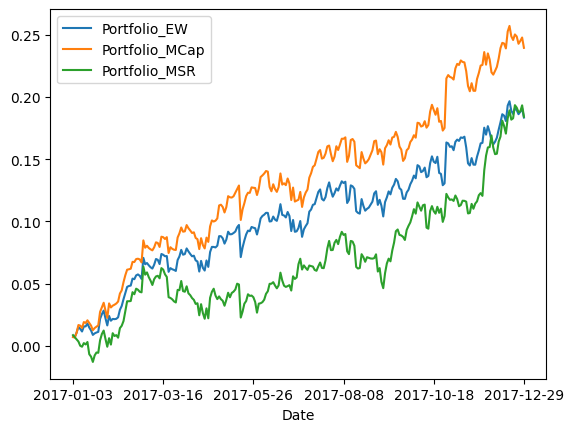

In [40]:
# Plot the cumulative returns
cumulative_returns_plot(['Portfolio_EW', 'Portfolio_MCap', 'Portfolio_MSR'])

The GMV portfolio

The global minimum volatility portfolio, or GMV portfolio, is the portfolio with the lowest standard deviation (risk) and the highest return for the given risk level.

Returns are very hard to predict, but volatilities and correlations tend to be more stable over time. This means that the GMV portfolio often outperforms the MSR portfolios out of sample even though the MSR would outperform quite significantly in-sample. Of course, out of sample results are what really matters in finance.

In [41]:
# Sort the portfolios by volatility
sorted_portfolios = RandomPortfolios.sort_values(by=['Volatility'], ascending=True)

sorted_portfolios

,AAPL weight,MSFT weight,XOM weight,JNJ weight,JPM weight,AMZN weight,GE weight,FB weight,T weight,Returns,Volatility,Sharpe
73,0.052723,0.121339,0.098848,0.051448,0.503273,0.108788,0.031648,0.012545,0.019388,0.142988,0.101787,1.404772
49,0.268158,0.029133,0.028774,0.104118,0.182823,0.265257,0.086988,0.029331,0.005418,0.219483,0.102127,2.149116
47,0.105705,0.009188,0.123591,0.090285,0.338884,0.066982,0.019296,0.023915,0.222155,0.280004,0.102440,2.733342
19,0.002463,0.105684,0.037822,0.152587,0.028217,0.172923,0.072008,0.406509,0.021787,0.128023,0.103395,1.238195
30,0.126956,0.127258,0.154576,0.187259,0.054853,0.053328,0.122633,0.080409,0.092729,0.127871,0.103701,1.233079
...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.173396,0.086043,0.224011,0.094063,0.096448,0.245219,0.060538,0.016860,0.003422,0.220630,0.198408,1.112002
11,0.016665,0.004661,0.147683,0.055089,0.103703,0.347594,0.041855,0.077114,0.205636,0.153613,0.198767,0.772829
74,0.058618,0.036371,0.042876,0.069684,0.039535,0.471494,0.017366,0.154361,0.109696,0.106237,0.198772,0.534464
88,0.057660,0.077318,0.001495,0.168213,0.220008,0.068106,0.097562,0.209170,0.100468,0.149280,0.199117,0.749713


In [42]:
# Extract the corresponding weights
GMV_weights = sorted_portfolios.iloc[0, 0:numstocks]

# Cast the GMV weights as a numpy array
GMV_weights_array = np.array(GMV_weights)

GMV_weights_array

array([0.05272261, 0.1213392 , 0.09884805, 0.05144777, 0.50327294,
       0.10878815, 0.03164825, 0.01254537, 0.01938767])

In [43]:
# Calculate the GMV portfolio returns
StockReturns['Portfolio_GMV'] = StockReturns.iloc[:, 0:numstocks].mul(GMV_weights_array, axis=1).sum(axis=1)

StockReturns

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T,Portfolio,Portfolio_EW,Portfolio_MCap,Portfolio_MSR,Portfolio_GMV
Date,,,,,,,,,,,,,,
2017-01-03,0.002849,0.007081,0.006980,0.005468,0.010894,0.005068,0.002848,0.015732,0.011521,0.008082,0.007605,0.007132,0.008744,0.008525
2017-01-04,-0.001119,-0.004474,-0.011002,-0.001640,0.001844,0.004657,0.000316,0.015660,-0.005811,0.000161,-0.000174,-0.000329,-0.001641,-0.000245
2017-01-05,0.005085,0.000000,-0.014907,0.010463,-0.009205,0.030732,-0.005678,0.016682,-0.002806,0.003448,0.003374,0.003903,-0.001755,-0.001981
2017-01-06,0.011148,0.008668,-0.000565,-0.004792,0.000116,0.019912,0.002855,0.022707,-0.019924,0.004660,0.004458,0.006068,-0.001699,0.003551
2017-01-09,0.009159,-0.003183,-0.016497,-0.000172,0.000697,0.001168,-0.004745,0.012074,-0.012585,-0.001372,-0.001565,-0.000478,-0.003400,-0.001308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,0.000000,0.000117,0.001431,-0.006664,-0.003524,-0.005448,0.001717,-0.001409,0.001543,-0.000825,-0.001360,-0.001280,-0.001641,-0.002487
2017-12-26,-0.025370,-0.001286,0.000119,-0.000214,-0.004002,0.007190,0.002877,-0.006828,0.003082,-0.003026,-0.002715,-0.004717,-0.002996,-0.002660
2017-12-27,0.000176,0.003630,-0.000953,0.003426,0.001869,0.004674,-0.002869,0.009262,-0.004352,0.001581,0.001651,0.001854,0.000389,0.001922


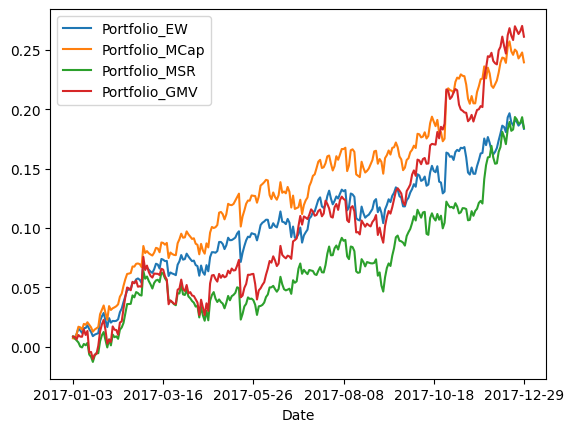

In [44]:
# Plot the cumulative returns
cumulative_returns_plot(['Portfolio_EW', 'Portfolio_MCap', 'Portfolio_MSR', 'Portfolio_GMV'])

Excess returns

In order to perform a robust analysis on your portfolio returns, you must first subtract the risk-free rate of return from your portfolio returns. The portfolio return minus the risk-free rate of return is known as the Excess Portfolio Return.

In the United States, the risk-free rate has been close to 0 since the financial crisis (2008), but this step is crucial for other countries with higher risk-free rates such as Venezuela or Brazil.

In [46]:
FamaFrenchData = pd.read_csv('FamaFrenchFactors.csv', index_col=0)
FamaFrenchData

,Portfolio,Market_Excess,SMB,HML,RMW,CMA,RF
Date,,,,,,,
2013-01-03,-0.005066,-0.0014,0.0014,0.0004,0.0020,0.0023,0.00000
2013-01-04,0.004024,0.0055,0.0019,0.0043,-0.0037,0.0027,0.00000
2013-01-07,0.004421,-0.0031,-0.0009,-0.0037,-0.0013,-0.0012,0.00000
2013-01-08,-0.004659,-0.0027,0.0004,-0.0007,-0.0012,0.0009,0.00000
2013-01-09,0.004636,0.0034,0.0024,-0.0041,-0.0007,-0.0015,0.00000
...,...,...,...,...,...,...,...
2017-12-22,-0.001360,-0.0007,-0.0019,-0.0020,-0.0005,0.0021,0.00004
2017-12-26,-0.002715,-0.0007,0.0031,-0.0006,-0.0017,0.0056,0.00004
2017-12-27,0.001651,0.0005,-0.0016,-0.0019,0.0006,-0.0012,0.00004


In [47]:
# Calculate excess portfolio returns
FamaFrenchData['Portfolio_Excess'] = FamaFrenchData['Portfolio'] - FamaFrenchData['RF']

FamaFrenchData

,Portfolio,Market_Excess,SMB,HML,RMW,CMA,RF,Portfolio_Excess
Date,,,,,,,,
2013-01-03,-0.005066,-0.0014,0.0014,0.0004,0.0020,0.0023,0.00000,-0.005066
2013-01-04,0.004024,0.0055,0.0019,0.0043,-0.0037,0.0027,0.00000,0.004024
2013-01-07,0.004421,-0.0031,-0.0009,-0.0037,-0.0013,-0.0012,0.00000,0.004421
2013-01-08,-0.004659,-0.0027,0.0004,-0.0007,-0.0012,0.0009,0.00000,-0.004659
2013-01-09,0.004636,0.0034,0.0024,-0.0041,-0.0007,-0.0015,0.00000,0.004636
...,...,...,...,...,...,...,...,...
2017-12-22,-0.001360,-0.0007,-0.0019,-0.0020,-0.0005,0.0021,0.00004,-0.001400
2017-12-26,-0.002715,-0.0007,0.0031,-0.0006,-0.0017,0.0056,0.00004,-0.002755
2017-12-27,0.001651,0.0005,-0.0016,-0.0019,0.0006,-0.0012,0.00004,0.001611


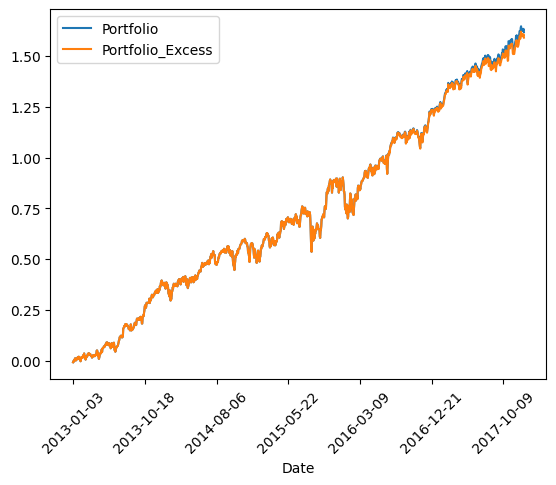

In [49]:
# Plot returns vs excess returns
CumulativeReturns = ((1+FamaFrenchData[['Portfolio','Portfolio_Excess']]).cumprod()-1)
CumulativeReturns.plot()
plt.xticks(rotation=45)
plt.show() # Notice how the excess return is only slightly less? That's because the risk free rate has been so low!

Calculating beta using co-variance

Beta is an essential component of many financial models, and is a measure of systematic risk, or exposure to the broad market. In the CAPM model, beta is one of two essential factors.

Historical beta can be estimated in a number of ways. In this exercise, you will use the following simple formula involving co-variance and variance to a benchmark market portfolio:

 
beta : Portfolio beta = cov(P,B) / var(B)
cov(P,B): The co-variance between the portfolio (P) and the benchmark market index (B)
var(B): The variance of the benchmark market index

In [50]:
# Calculate the co-variance matrix between Portfolio_Excess and Market_Excess
covariance_matrix = FamaFrenchData[['Portfolio_Excess', 'Market_Excess']].cov()

covariance_matrix

,Portfolio_Excess,Market_Excess
Portfolio_Excess,0.000070,0.000057
Market_Excess,0.000057,0.000059


In [51]:
# Extract the co-variance co-efficient
covariance_coefficient = covariance_matrix.iloc[0, 1]
covariance_coefficient

5.7261263381549676e-05

In [52]:
# Calculate the benchmark variance
benchmark_variance = FamaFrenchData['Market_Excess'].var()
benchmark_variance

5.880335088211895e-05

In [53]:
# Calculating the portfolio market beta
portfolio_beta = covariance_coefficient / benchmark_variance
portfolio_beta #  For every 1.0% rise (or fall) in the market, you can expect your portfolio to rise (fall) roughly 0.97%.

0.9737755165745461

Calculating beta with CAPM

There are many ways to model stock returns, but the Capital Asset Pricing Model, or CAPM, is one the most well known:

(Excess ReturnPortfolio "Rp - Rf") = 𝛽*(Excess Return Benchmark "Rb - Rf")

Rf: The regional risk free-rate

beta : Portfolio beta, or exposure, to the broad market portfolio B

You can call the .fit() method from statsmodels.formula.api on an .ols(formula, data) model object to perform the analysis, and the .summary() method on the analysis object to anaylze the results.

In [60]:
# Define the regression formula
CAPM_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess', data=FamaFrenchData)

CAPM_fit = CAPM_model.fit()

CAPM_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Portfolio_Excess   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     4854.
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        06:27:37   Log-Likelihood:                 5226.5
No. Observations:                1258   AIC:                        -1.045e+04
Df Residuals:                    1256   BIC:                        -1.044e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0002      0.000      2.009      0.045    5.03e-06       0.000
Market_Excess     0.9738      0.014     69.669      0.000       0.946       1.001
==============================================================================
Omnibus:                      372.020   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3087.179
Skew:                           1.128   Prob(JB):                         0.00
Kurtosis:                      10.335   Cond. No.                         130.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
# Print adjusted r-squared of the fitted regression
print(CAPM_fit.rsquared_adj)

0.7942627160017839


In [62]:
# Extract the beta
regression_beta = CAPM_fit.params['Market_Excess']
print(regression_beta)

0.973775516574546


The Fama French 3-factor model

The Fama-French model famously adds two additional factors to the CAPM model to describe asset returns:

Rp = Rf + 𝛽*(Rb - Rf) + b_SMB*SMB + b_HML*HML + alpha

SMB: The small minus big factor
b_SMB: Exposure to the SMB factor
HML: The high minus low factor
b_HML: Exposure to the HML factor
alpha: Performance which is unexplained by any other factors
beta: Beta to the broad market portfolio B

In [67]:
# Define the regression formula
FamaFrench_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess + SMB + HML', data=FamaFrenchData)

# Fit the regression
FamaFrench_fit = FamaFrench_model.fit()

FamaFrench_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Portfolio_Excess   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     1902.
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        08:46:30   Log-Likelihood:                 5309.4
No. Observations:                1258   AIC:                        -1.061e+04
Df Residuals:                    1254   BIC:                        -1.059e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0002      0.000      1.820      0.069   -1.43e-05       0.000
Market_Excess     1.0155      0.014     75.192      0.000       0.989       1.042
SMB              -0.2622      0.021    -12.432      0.000      -0.304      -0.221
HML              -0.1087      0.021     -5.065      0.000      -0.151      -0.067
==============================================================================
Omnibus:                      433.585   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4429.287
Skew:                           1.293   Prob(JB):                         0.00
Kurtosis:                      11.821   Cond. No.                         217.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
# Extract the adjusted r-squared
regression_adj_rsq = FamaFrench_fit.rsquared_adj
print(regression_adj_rsq)

0.8193910088585152


p-values and coefficients

You can use the .pvalues attribute on a fitted smf.ols regression model to retrieve the p-values for each coefficient.

Normally, p-values less than 0.05 are considered statistically significant.

Coefficients can be extracted from the fitted regression object using the .params attribute.

In this example, a statistically significant negative SMB ('Small Minus Big') coefficient would signify a factor exposure to large cap stocks, while a positive coefficient would signify an exposure to small cap stocks.

In [69]:
# Extract the p-value of the SMB factor
smb_pval = FamaFrench_fit.pvalues['SMB']

# If the p-value is significant, print significant
if smb_pval < 0.05:
    significant_msg = 'significant'
else:
    significant_msg = 'not significant'

# Print the SMB coefficient
smb_coeff = FamaFrench_fit.params['SMB']
print("The SMB coefficient is ", smb_coeff, "the p-value is ", smb_pval," and is ", significant_msg)

The SMB coefficient is  -0.2621515274319262 the p-value is  1.5200513481258108e-33  and is  significant


The efficient market and alpha

The alpha left over by the regression is unexplained performance due to unknown factors. In a regression model, this is simply the coefficient of the intercept.

There are two general schools of thought as to why:

The model simply needs to be expanded. When you have found all of the missing economic factors, you can explain all stock and portfolio returns. This is known as the Efficient Market Hypothesis.

There is a degree of unexplainable performance that no model will ever capture reliably. Perhaps it is due to skill, timing, intuition or luck, but investors should seek to maximize their alpha.

In [70]:
# Calculate your portfolio alpha
portfolio_alpha = FamaFrench_fit.params['Intercept']
print(portfolio_alpha)

0.0001832666520318304


In [71]:
# Annualize your portfolio alpha
portfolio_alpha_annualized = ((1+portfolio_alpha)**252)-1
print(portfolio_alpha_annualized)

0.04726181730280854


The 5-factor model

In 2015, Fama and French extended their previous 3-factor model, adding two additional factors:

RMW: Profitability

CMA: Investment

The RMW factor represents the returns of companies with high operating profitability versus those with low operating profitability, and the CMA factor represents the returns of companies with aggressive investments versus those who are more conservative.

In [72]:
# Define the regression formula
FamaFrench5_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess + SMB + HML + RMW + CMA', data=FamaFrenchData)

# Fit the regression
FamaFrench5_fit = FamaFrench5_model.fit()

FamaFrench5_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Portfolio_Excess   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     1289.
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:05:16   Log-Likelihood:                 5373.9
No. Observations:                1258   AIC:                        -1.074e+04
Df Residuals:                    1252   BIC:                        -1.070e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0002   9.58e-05      1.819      0.069   -1.37e-05       0.000
Market_Excess     0.9728      0.014     71.773      0.000       0.946       0.999
SMB              -0.2739      0.021    -13.049      0.000      -0.315      -0.233
HML               0.0714      0.026      2.727      0.006       0.020       0.123
RMW              -0.0740      0.034     -2.162      0.031      -0.141      -0.007
CMA              -0.4685      0.042    -11.132      0.000      -0.551      -0.386
==============================================================================
Omnibus:                      379.546   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3276.701
Skew:                           1.144   Prob(JB):                         0.00
Kurtosis:                      10.568   Cond. No.                         486.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
# Extract the adjusted r-squared
regression_adj_rsq = FamaFrench5_fit.rsquared_adj
print(regression_adj_rsq)

0.8367245019225793
